In [1]:
import os
os.environ['OMP_NUM_THREADS']='2'
os.environ['LD_LIBRARY_PATH']=''

In [2]:
import numpy as np
import h5py
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from tqdm.std import trange
from torch.utils.data import dataloader
from pixelshuffle1d import PixelShuffle1D, PixelUnshuffle1D

/home/pz281@ad.eng.cam.ac.uk/anaconda3/envs/torch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [30]:
def generate_data(N,type):
    h=1/N
    x=np.arange(0,1.0001,h)
    y=np.arange(0,1.0001,h)
    
    w=np.zeros((N+1,N+1))

    for j in range (0,N):
        w[0,j]=0 #Lower Boundary
        w[N,j]=0 #Upper Boundary
    
    N2=(N-1)*(N-1)
    A=np.zeros((N2,N2))
    ## Diagonal            
    for i in range (0,N-1):
        for j in range (0,N-1):           
            A[i+(N-1)*j,i+(N-1)*j]=-4

    # LOWER DIAGONAL        
    for i in range (1,N-1):
        for j in range (0,N-1):           
            A[i+(N-1)*j,i+(N-1)*j-1]=1   
    # UPPPER DIAGONAL        
    for i in range (0,N-2):
        for j in range (0,N-1):           
            A[i+(N-1)*j,i+(N-1)*j+1]=1   

    # LOWER IDENTITY MATRIX
    for i in range (0,N-1):
        for j in range (1,N-1):           
            A[i+(N-1)*j,i+(N-1)*(j-1)]=1        
        
        
    # UPPER IDENTITY MATRIX
    for i in range (0,N-1):
        for j in range (0,N-2):           
            A[i+(N-1)*j,i+(N-1)*(j+1)]=1
    Ainv=np.linalg.inv(A) 
    
    r=np.zeros(N2)
    
    a = np.random.uniform(0,2)
    b = np.random.uniform(0,2)
    c = np.random.uniform(-2*np.pi,2*np.pi)
    d = np.random.uniform(-2*np.pi,2*np.pi)

    # vector r      
    for i in range (0,N-1):
        for j in range (0,N-1):
            if type == "mean":      
                r[i+(N-1)*j]=-(8*np.pi**2) * np.sin(2*np.pi*x[i+1]) * np.sin(2*np.pi*y[j+1])*h**2
            elif type == "test":
                r[i+(N-1)*j]=-(8*np.pi**2) * np.sin(2*2*np.pi*x[i+1]) * np.sin(2*np.pi*(y[j+1]+np.pi))*h**2
            else:
                r[i+(N-1)*j]=-(8*np.pi**2) * np.sin(2*a*np.pi*(x[i+1]+c)) * np.sin(2*b*np.pi*(y[j+1]+d))*h**2
    
    C=np.dot(Ainv,r)
    w[1:N,1:N]=C.reshape((N-1,N-1))
    
    return w, r, A, x, y
    

In [15]:
N_low = 19
N_high = 99
w_low, r_low, A_low, x_low, y_low = generate_data(N_low,"mean")
w_high, r_high, A_high, x_high, y_high = generate_data(N_high,"mean")
GT = w_high

In [6]:
class UpScale(torch.nn.Module):
    def __init__(self):
        super(UpScale, self).__init__()
        self.layer1 = torch.nn.Conv2d(in_channels=1, out_channels=25, kernel_size=3, stride=1,padding=1)
        self.act1 = torch.nn.ReLU()
        self.layer2 = torch.nn.Conv2d(in_channels=25, out_channels=50, kernel_size=3, stride=1,padding=1)
        #self.layer3 = torch.nn.Conv1d(in_channels=6, out_channels=6, kernel_size=3, stride=1,padding=1)
        self.layer4 = torch.nn.Conv2d(in_channels=50, out_channels=25, kernel_size=3, stride=1,padding=1)
        self.PReLU = torch.nn.PReLU()
        self.shuffle = torch.nn.PixelShuffle(5)
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.PReLU(x)
        #x = self.layer3(x)+x1
        x = self.layer4(x)
        x = self.shuffle(x)

        # log_probs = torch.nn.functional.log_softmax(x, dim=1)

        return x

model = UpScale()
input = torch.tensor(w_low.reshape(1, w_low.shape[0],-1))
input = input.to(torch.float32)
print(model(input).shape)

torch.Size([1, 100, 100])


In [11]:
# Initialise network
model = UpScale()
optim = torch.optim.Adam(model.parameters(), lr = 0.001)

# Initialise parameters
sigma = 1
# Sigma = torch.eye((N_high+1)**2)
epoch_number = 2000
minimum_loss = 10000
w_high = torch.tensor(w_high.reshape(1,w_high.shape[0],-1))
w_high = w_high.to(torch.float32)
w_high = w_high.reshape(1,-1)

# Sample from p(u^l)
'''sample_ul = []
for i in range(N_samples):
    u = np.zeros((1,N_low))
    u[0,1:N_low-1] = np.random.multivariate_normal(mean_u.ravel(),covariance_u).reshape(1,-1)
    sample_ul.append(u)'''

for epoch in range(epoch_number):
    input = w_low
    input = torch.tensor(input.reshape(1,input.shape[0],-1))
    input = input.to(torch.float32)
    output = model(input)
    output = output.reshape(1,-1)
    
    
    optim.zero_grad()
    loss = torch.sum((output-w_high)**2)/output.shape[0]
    print(loss)
    if loss.item() < minimum_loss:
        torch.save(model.state_dict(), 'best_2D_model_nonprob.pth')
        minimum_loss = loss
    loss.backward()
    optim.step()
    
    '''if (epoch+1)%100 == 0:
        print("Epoch: {}".format(epoch), "Loss: {}".format(loss.item()))'''
    print("Epoch: {}".format(epoch), "Loss: {}".format(loss.item()))


/tmp/ipykernel_537335/62297685.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w_high = torch.tensor(w_high.reshape(1,w_high.shape[0],-1))


tensor(2586.4365, grad_fn=<DivBackward0>)
Epoch: 0 Loss: 2586.4365234375
tensor(2208.3237, grad_fn=<DivBackward0>)
Epoch: 1 Loss: 2208.32373046875
tensor(1875.0336, grad_fn=<DivBackward0>)
Epoch: 2 Loss: 1875.0335693359375
tensor(1524.7062, grad_fn=<DivBackward0>)
Epoch: 3 Loss: 1524.7061767578125
tensor(1142.6075, grad_fn=<DivBackward0>)
Epoch: 4 Loss: 1142.6075439453125
tensor(755.3867, grad_fn=<DivBackward0>)
Epoch: 5 Loss: 755.38671875
tensor(427.2503, grad_fn=<DivBackward0>)
Epoch: 6 Loss: 427.25030517578125
tensor(241.7972, grad_fn=<DivBackward0>)
Epoch: 7 Loss: 241.7971954345703
tensor(236.6507, grad_fn=<DivBackward0>)
Epoch: 8 Loss: 236.65072631835938
tensor(333.4961, grad_fn=<DivBackward0>)
Epoch: 9 Loss: 333.49609375
tensor(398.9812, grad_fn=<DivBackward0>)
Epoch: 10 Loss: 398.9812316894531
tensor(371.3637, grad_fn=<DivBackward0>)
Epoch: 11 Loss: 371.36370849609375
tensor(283.1923, grad_fn=<DivBackward0>)
Epoch: 12 Loss: 283.19232177734375
tensor(194.2213, grad_fn=<DivBackwar

In [13]:
# Test with input A^(-1)b
model = UpScale()
model.load_state_dict(torch.load('best_2D_model_nonprob.pth'))
input = w_low
input = torch.tensor(input.reshape(1,input.shape[0],-1))
input = input.to(torch.float32)
output = model(input)
y_input = input.detach().numpy()
y = output.detach().numpy()

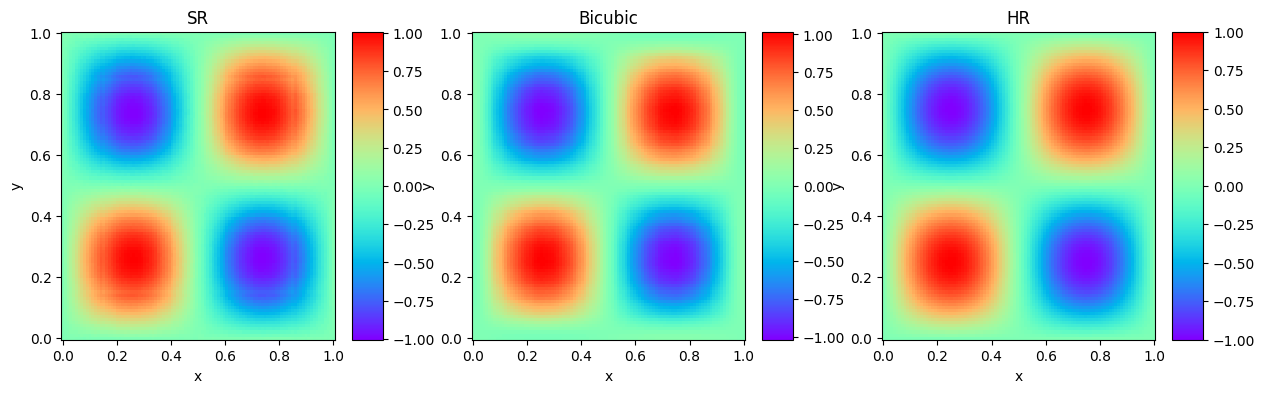

SR L2 Error: 0.00028800943632463776
Bicubic L2 Error: 0.0035608024351483523


In [16]:
fig = plt.figure(figsize=(15,4))
# Around 200 epochs
'''plt.subplot(1,4,1)
plt.pcolormesh(x_low,y_low,w_low, cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(0, 0.15)
plt.title('LR')
plt.xlabel('x')
plt.ylabel('y')'''
plt.subplot(1,3,1)
plt.pcolormesh(x_high, y_high, y[0], cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(0, 0.15)
plt.title('SR')
plt.xlabel('x')
plt.ylabel('y')
plt.subplot(1,3,2)
w_high_bicubic = cv2.resize(w_low, dsize=(100,100), interpolation=cv2.INTER_CUBIC)
plt.pcolormesh(x_high, y_high, w_high_bicubic, cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(0, 0.15)
plt.title('Bicubic')
plt.xlabel('x')
plt.ylabel('y')
# Around 200 epochs
plt.subplot(1,3,3)
plt.pcolormesh(x_high, y_high, GT, cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(0, 0.15)
plt.title('HR')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


error1 = abs(GT - y[0])
error2 = abs(w_high_bicubic - GT)
print('SR L2 Error:', (error1**2).sum()/error1.shape[0]**2)
print('Bicubic L2 Error:', (error2**2).sum()/error2.shape[0]**2)

In [31]:
N_low = 19
N_high = 99
w_low, r_low, A_low, x_low, y_low = generate_data(N_low,"test")
w_high, r_high, A_high, x_high, y_high = generate_data(N_high,"test")

In [34]:
model = UpScale()
model.load_state_dict(torch.load('best_2D_model_nonprob.pth'))
input = w_low
input = torch.tensor(input.reshape(1,input.shape[0],-1))
input = input.to(torch.float32)
output = model(input)
y_input = input.detach().numpy()
y = output.detach().numpy()

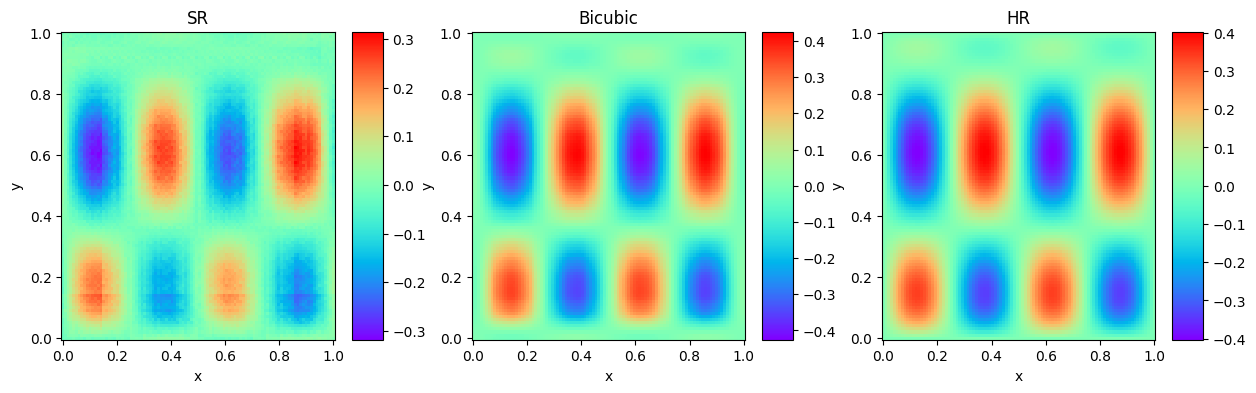

SR L2 Error: 0.004838023682677197
Bicubic L2 Error: 0.001189675823267274


In [35]:
fig = plt.figure(figsize=(15,4))
# Around 200 epochs
'''plt.subplot(1,4,1)
plt.pcolormesh(x_low,y_low,w_low, cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(0, 0.15)
plt.title('LR')
plt.xlabel('x')
plt.ylabel('y')'''
plt.subplot(1,3,1)
plt.pcolormesh(x_high, y_high, y[0], cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(0, 0.15)
plt.title('SR')
plt.xlabel('x')
plt.ylabel('y')
plt.subplot(1,3,2)
w_high_bicubic = cv2.resize(w_low, dsize=(100,100), interpolation=cv2.INTER_CUBIC)
plt.pcolormesh(x_high, y_high, w_high_bicubic, cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(0, 0.15)
plt.title('Bicubic')
plt.xlabel('x')
plt.ylabel('y')
# Around 200 epochs
plt.subplot(1,3,3)
plt.pcolormesh(x_high, y_high, w_high, cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(0, 0.15)
plt.title('HR')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


error1 = abs(w_high - y[0])
error2 = abs(w_high_bicubic - w_high)
print('SR L2 Error:', (error1**2).sum()/error1.shape[0]**2)
print('Bicubic L2 Error:', (error2**2).sum()/error2.shape[0]**2)